# Forecasting Stock Prices using ARIMA Model - Deep Borkar

### Please refer 'forecast_S&P_dataExtraction' file to extract stock price data. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA


from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')


# 1. Data Loading

Data has already been extracted and stored in a csv. <br>
We read the data in seperate DataFrames.

In [2]:
sp500_info = pd.read_csv('data/sp500_info.csv', index_col=0)
sp400_info = pd.read_csv('data/sp400_info.csv', index_col=0)

In [3]:
sp500_data = pd.read_csv('data/sp500.csv', index_col=0)
sp400_data = pd.read_csv('data/sp400.csv', index_col=0)

sp500_data.index = pd.to_datetime(sp500_data.index, format='%Y-%m-%d')
sp400_data.index = pd.to_datetime(sp400_data.index, format='%Y-%m-%d')

Here I copy the data in a different variable to work with.

In [4]:
sp500 = sp500_data.copy()
sp400 = sp400_data.copy()

Get Shape of the Data

In [5]:
print(sp500.shape)
print(sp400.shape)

(12549, 505)
(9304, 399)


# 2. Data Preprocessing

These are the functions created to preprocess the Data. <br>
The data needs to be cleaned before using it to forecast in a model.

In [6]:
def check_neg(df):
    b = df[df < 0].any()
    print("Column with negative value: ", end = '')
    print(b[b == True].index)

def simple_plot(ts):
    plt.plot(ts)
    plt.title(ts.name)
    
def check_stationarity(ts):
    ts.dropna(inplace=True)
    dftest = adfuller(ts, autolag='AIC')
    dfresults = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'], dtype='object')
    for key,value in dftest[4].items():
        dfresults['Critical Value (%s)'%key] = value
    dfresults['Stationarity @ 1%'] = (dfresults['Test Statistic'] < dfresults['Critical Value (1%)']).astype('bool')
    dfresults['Stationarity @ 5%'] = (dfresults['Test Statistic'] < dfresults['Critical Value (5%)']).astype('bool')
    dfresults['Stationarity @ 10%'] = (dfresults['Test Statistic'] < dfresults['Critical Value (10%)']).astype('bool')
    return list(dfresults)

def get_dfresults(df):
    res = pd.DataFrame(index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used',\
                                'Critical Value (1%)', 'Critical Value (5%)', 'Critical Value (10%)',\
                                'Stationary @ 1%', 'Stationary @ 5%', 'Stationary @ 10%'])
    for t in list(df.columns):
      res[t] = check_stationarity(df[t])
        
      return res

#### 2.1 Removing Large Negative values in Yahoo Finance Data source

There were 2 Stocks from Yahoo finance with high negative values which would skew our predictions. <br>
So we check the data for those values and remove them.

In [7]:
#check negative values
check_neg(sp500)
check_neg(sp400)

print()
print("Removing negative values...")
sp500['SEE'][sp500['SEE'] < 0] = np.nan
sp400['AAN'][sp400['AAN'] < 0] = np.nan

check_neg(sp500)
check_neg(sp400)

Column with negative value: Index(['SEE'], dtype='object')
Column with negative value: Index(['AAN'], dtype='object')

Removing negative values...
Column with negative value: Index([], dtype='object')
Column with negative value: Index([], dtype='object')


#### 2.2 Removing Duplicate Tickers from 900 Companies

In [8]:
def check_duplicates(l):
    duplicates = set([x for x in l if l.count(x) > 1])
    print("Duplicate Tickers in S&P 500 and S&P 400: ", end='')
    print(duplicates)
check_duplicates(list(sp500.columns) + list(sp400.columns))

Duplicate Tickers in S&P 500 and S&P 400: {'ATO', 'WRB', 'ROL', 'ODFL'}


In [9]:
print("Removing Duplicates...")
sp500.drop('ATO', axis=1, inplace=True)
sp400.drop('ROL', axis=1, inplace=True)
print()

check_duplicates(list(sp500.columns) + list(sp400.columns))

Removing Duplicates...

Duplicate Tickers in S&P 500 and S&P 400: {'WRB', 'ODFL'}


# 3. Tool to Plot any stock to visualize price over time.

Enter any ticker and it will give you a plot of that stock. If ticker not in list, it will ask you to enter valid ticker again.

Enter Ticker: ntfx
Try Again
Enter Ticker: nflx


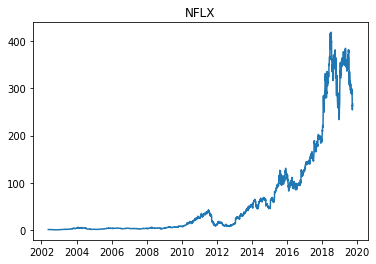

In [10]:
#Visualize stock price series
def which_sp(t):
    if t in sp500.columns:
        return 'sp500'
    elif t in sp400.columns:
        return 'sp400'
    else:
        return None

while(True):
    ticker = (input("Enter Ticker: ")).upper()
    if which_sp(ticker) == 'sp500':
        simple_plot(sp500[ticker])
        break
    elif which_sp(ticker) == 'sp400':
        simple_plot(sp400[ticker])
        break
    else:
        print("Try Again")
        pass

Above plot represents price for NetFlix over the years.

# 4. Check for Staionarity

Here I have already tested all the 900 stocks for Stationarity but you can do it again by entering 1. If not then click 2.

In [12]:
run_dflr = input("Enter 1 to run Dickey-Fuller Test on all stocks.(ETA: 8 mins)\nEnter 2 to Ignore.\n")
if run_dflr == '1':
    

    sp500_dfresults = get_dfresults(sp500)
    print("S&500 Done.")# 5 mins
    sp400_dfresults = get_dfresults(sp400)
    print("S&P400 Done.")# 2:40 mins

    sp500_dfresults.T.to_csv('test_results/sp500_dfresults.csv', encoding='utf-8')
    sp400_dfresults.T.to_csv('test_results/sp400_dfresults.csv', encoding='utf-8')
else:
    pass

sp500_dflr = pd.read_csv('test_results/sp500_dfresults.csv', index_col=0)
sp400_dflr = pd.read_csv('test_results/sp400_dfresults.csv', index_col=0)

print("Dickey-Fuller Test Results Read.")

Enter 1 to run Dickey-Fuller Test on all stocks.(ETA: 8 mins)
Enter 2 to Ignore.
2
Dickey-Fuller Test Results Read.


There are stocks which are stationary but most stocks are not stationary. So we need to make them stationary

# 5. Staionarize the Data

One of the most common method of stationarizing the data is to take the log and differencing it with its lagged value.

In [13]:
#log

log_sp500 = np.log(sp500)
log_sp400 = np.log(sp400)

log_diff_sp500 = log_sp500 - log_sp500.shift()
log_diff_sp400 = log_sp400 - log_sp400.shift()


Now we check for stationarity again after differencing 

In [15]:
run_dflr = input("Enter 1 to run Dickey-Fuller Test on all log diff stocks.(ETA: 8 mins)\nEnter 2 to Ignore.\n")
if run_dflr == '1':
    
    sp500_logdiff = get_dfresults(log_diff_sp500)
    print("S&500 Done.")# 5 mins
    sp400_logdiff = get_dfresults(log_diff_sp400)
    print("S&P400 Done.")# 2:40 mins

    sp500_logdiff.T.to_csv('test_results/sp500_logdiff.csv', encoding='utf-8')
    sp400_logdiff.T.to_csv('test_results/sp400_logdiff.csv', encoding='utf-8')

else:
    pass

sp500_logddflr = pd.read_csv('test_results/sp500_logdiff.csv', index_col=0)
sp400_logdflr = pd.read_csv('test_results/sp400_logdiff.csv', index_col=0)

Enter 1 to run Dickey-Fuller Test on all log diff stocks.(ETA: 8 mins)
Enter 2 to Ignore.
2


As you can see below, after differencing all stocks reject the Null Hypothesis for Dickey-Fuller test. All stocks are stationary.

In [16]:
sp500_logddflr[sp500_logddflr['Stationary @ 5%'] == False].any().sum()

0

In [17]:
sp400_logdflr[sp400_logdflr['Stationary @ 5%'] == False].any().sum()

0

# 6. Functions used for Model Training and Testing

In [18]:
def split_data(t, ind):
    ts = pd.DataFrame()
    if ind == 'sp500':
        ts['price'] = sp500[t]
        ts['log'] = log_sp500[t]
        ts['log_diff'] = log_diff_sp500[t]
    elif ind == 'sp400':
        ts['price'] = sp400[t]
        ts['log'] = log_sp400[t]
        ts['log_diff'] = log_diff_sp400[t]
    train = ts[:'2019-06-01']
    test = ts['2019-06-01':] 
    return train, test

def get_parameters(ts):
    res = sm.tsa.arma_order_select_ic(ts['log_diff'].dropna(), ic='aic', trend='nc')
    p = res['aic_min_order'][0]
    q = res['aic_min_order'][1]
    return p,q

def model_train(train, test, p, q):
    predictions = list()
    history = [x for x in train['log_diff'].dropna()]
    for t in tqdm(range(len(test))):
        # fit model
        model = ARIMA(history, order=(p,1,q))
        model_fit = model.fit()
        # one step forecast
        yhat = model_fit.forecast()[0]
        # store forecast and ob
        predictions.append(yhat)
        history.append(test['log_diff'][t])

    pred = pd.Series([float(i) for i in predictions], index = test.index)
    check_prediction_diff(pred, test)
    
def check_prediction_diff(predict_diff, test):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(test.shape[0]) * np.log(test['price'])[0], index = test.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_log)

    plt.plot(test['price'], label = "Test Set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% np.sqrt(sum((predict-test['price'])**2)/len(test['price'])))
    plt.show()

# 7. Tool to Forecast any stock data using ARIMA Model 

Enter the ticker for the stock you want to forecast.

In [64]:
while(True):
    ticker = (input("Enter Ticker: ")).upper()
    if which_sp(ticker) == 'sp500':
        index = 'sp500'
        break
    elif which_sp(ticker) == 'sp400':
        index = 'sp400'
        break
    else:
        print("Try Again")
        pass

Enter Ticker: TSLA
Try Again
Enter Ticker: tsla
Try Again
Enter Ticker: dis


Here we select Disney - DIS stock

#### 7.1 Split Data into Train and Test

Test data set contains latest 3 months data from June 2019 -  Sept 30, 2019

In [20]:
#split data
train, test = split_data(ticker, index)

#### 7.2 Get p & q parameters for ARIMA using AIC order select pre built function

In [21]:
#get parameters for p & q
p, q = get_parameters(train)

In [22]:
print("Residual Order: ("+str(p)+","+str(q)+")")

Residual Order: (3,1)


#### 7.3 AR Model 

Using AR Model gives a better RMSE as MA(q) parameter tries to smoothen the prediction.(Check next plot to see the difference)

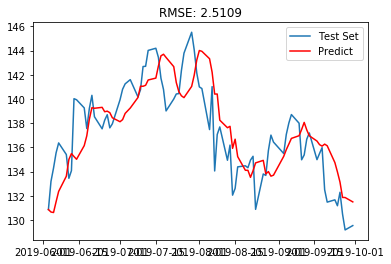

In [23]:
model_train(train, test, p, 0)

#### 7.4 ARIMA Model

Here we use both p = 3 and q = 1parameters:

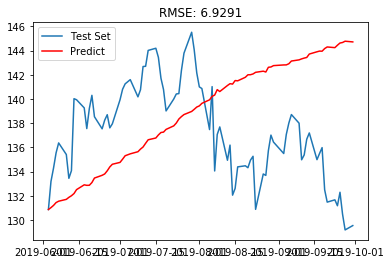

In [24]:
model_train(train, test, p, q)

In [44]:
train

,price,log,log_diff
Date,,,
1970-01-02,0.276762,-1.284598,NaN
1970-01-05,0.268438,-1.315135,-0.030537
1970-01-06,0.263236,-1.334705,-0.019570
1970-01-07,0.269999,-1.309338,0.025367
1970-01-08,0.276762,-1.284598,0.024740
...,...,...,...
2019-05-24,131.186722,4.876622,0.000452
2019-05-28,131.018784,4.875341,-0.001281
2019-05-29,129.981491,4.867392,-0.007949


# 8. Creating a Price Weighted Index using S&P500 Stocks of the 2018-2019 year.

The following function filters the data by selecting only 1 year Sept 2018 - Sept 2019 data and removing columns which have null values for this year.

In [28]:
def filter_index(df):
    df = df.iloc[df.shape[0] - 252:,:]
    drp = df.isnull().sum()
    drp = drp[drp > 0]
    df = df.drop(list(drp.index), axis=1)
    return df

sp500_index = filter_index(sp500)
sp400_index = filter_index(sp400)

As you can see below, there are no Null values in our 252 records (1 year trading days)

In [29]:
sp500_index.isnull().any().sum()

0

In [30]:
sp400_index.isnull().any().sum()

0

#### 8.1 Creating the Price Weighted Index

In [130]:
l5 = []
for i in range(sp500_index.shape[0]): # Calculate mean of each day
    l5.append(sp500_index.iloc[i].mean()) # Calculate mean of each day
    
ind5 = pd.DataFrame({'Average':l5}, index=sp500_index.index) # create DataFrame to store it

ind5['Index'] = np.zeros(252) # Our index values 
ind5['Index'][0] = 2744.45 # Base Value for our index which is the day 1 

for i in range(1, 252):
    ind5['Index'][i] = (ind5['Average'][i] / ind5['Average'][i-1]) * ind5['Index'][i-1] 
    # So index value for a day= (Average(day 2) / Average(day 1)) * Index Value(day 1)

#### 8.2 Check Stationarity for Index

In [131]:
check_stationarity(ind5['Index']) # Check Stationarity

[-0.9964512320439892,
 0.7545564310947632,
 0,
 251,
 -3.4566744514553016,
 -2.8731248767783426,
 -2.5729436702592023,
 False,
 False,
 False]

####  8.3 Differencing to Stationarize data and use it in the model

In [132]:
ind5_log = np.log(ind5['Index'])
ind5_diff  = ind5_log - ind5_log.shift() 

Data has been Stationarized.

In [133]:
check_stationarity(ind5_diff)

[-15.668140853160685,
 1.5244687863938663e-28,
 0,
 250,
 -3.456780859712,
 -2.8731715065600003,
 -2.572968544,
 True,
 True,
 True]

####  8.4 Split data into Train and  test

In [134]:
ind_df = pd.DataFrame({'Index': ind5['Index'], 'log':ind5_log, 'log_diff':ind5_diff})
train_ind = ind_df[:'2019-06-01']
test_ind = ind_df['2019-06-01':]

In [135]:
sp500_ind =  web.DataReader('^GSPC', 'yahoo', '2019-06-03', '2019-09-30')['Adj Close']
sp500_ind = pd.DataFrame({'price': sp500_ind})

#### 8.5 Get Parameters for the Index data

In [136]:
p_i, q_i = get_parameters(train_ind)
print("Residual Order: ("+str(p_i)+","+str(q_i)+")")

Residual Order: (2,2)


#### 8.6 Run AR and ARIMA Model

In [137]:
def model_train_i(train, test, p, q):
    predictions = list()
    history = [x for x in train['log_diff'].dropna()]
    for t in tqdm(range(len(test))):
        # fit model
        model = ARIMA(history, order=(p,1,q))
        model_fit = model.fit()
        # one step forecast
        yhat = model_fit.forecast()[0]
        # store forecast and ob
        predictions.append(yhat)
        history.append(test['log_diff'][t])

    pred = pd.Series([float(i) for i in predictions], index = test.index)
    check_prediction_diff_i(pred, test)
    
def check_prediction_diff_i(predict_diff, test):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(test.shape[0]) * np.log(test['Index'])[0], index = test.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_log)

    plt.plot(test['Index'], label = "S&P 900")
    plt.plot(sp500_ind['price'], label = "S&P 500")
    plt.plot(predict, color = 'red', label = "Predict")
    
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% np.sqrt(sum((predict-test['Index'])**2)/len(test['Index'])))
    plt.show()

#### 8.6.1 AR Model for Index

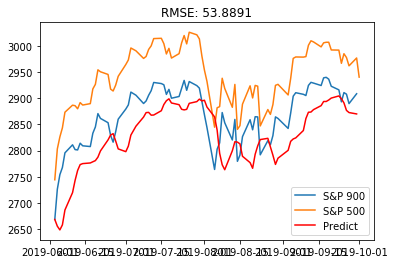

In [138]:
model_train_i(train_ind, test_ind, p_i, 0)

#### 8.6.2 ARIMA Model for Index

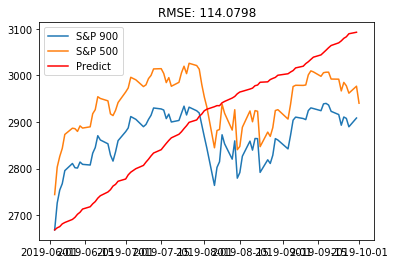

In [140]:
model_train_i(train_ind, test_ind, p_i, q_i)

In conclusion, this is basic model with different parameters tried to find the best RMSE. <br> With every stock, data presents different trend and noise. <br> It is important to tune these parameters and also use different models to understand which is better relatively.